# Introduction

Hello, my name is Suriya Supo. This is my project on NLP, showcasing an end-to-end implementation starting from data import to model deployment. The main objectives of this project are:

1. To understand the patterns of both positive and negative sentiments in the data.
2. To build an algorithm capable of learning and classifying sentiment types.
3. To create a system that can effectively classify sentiments in a practical API format.

The dataset used in this project was sourced from https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset, which is an excellent resource. Let's dive into the project!

In [ ]:
# Install required libraries for natural language processing and topic modeling
!pip install nltk
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Import essential libraries for data manipulation, visualization, and analysis
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For creating static visualizations
%matplotlib inline  # To display plots inline in Jupyter Notebook
import seaborn as sns  # For advanced data visualization
import warnings  # To handle warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# Import regex for text processing
import re

# Import NLTK for natural language processing tasks
import nltk
from nltk.tokenize import word_tokenize  # For tokenizing text into words
from nltk.stem import WordNetLemmatizer  # For lemmatizing words
from nltk.corpus import wordnet  # To retrieve word meanings and synonyms
nltk.download('punkt_tab')  # Download tokenizer data
nltk.download('stopwords')  # Download stopwords list
nltk.download('wordnet')  # Download WordNet for lemmatization
from nltk.corpus import stopwords  # For removing stopwords
from wordcloud import WordCloud  # For generating word clouds
from collections import Counter  # For counting frequencies of elements in collections
from bertopic import BERTopic  # For topic modeling using BERTopic
import json  # For working with JSON data

# Import Scikit-learn for machine learning tasks
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization using TF-IDF
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.metrics import f1_score, precision_score, recall_score  # Metrics for model evaluation
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from xgboost import XGBClassifier  # XGBoost Classifier
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
from sklearn.metrics import classification_report  # To generate detailed classification reports
import joblib  # For saving and loading machine learning models

# Import PyTorch for deep learning tasks
import torch
from torch.nn.utils.rnn import pad_sequence  # For padding sequences to the same length
from torch.utils.data import DataLoader, TensorDataset  # For creating data loaders and datasets
import torch.nn as nn  # For building neural network layers

# For working with zip files (e.g., extracting datasets from compressed archives)
from zipfile import ZipFile


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Download Spotify dataset from Kaggle
!kaggle datasets download -d alexandrakim2201/spotify-dataset

Dataset URL: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/2.90M [00:00<?, ?B/s]
100% 2.90M/2.90M [00:00<00:00, 106MB/s]


In [ ]:
# Extract the downloaded zip file
!unzip spotify-dataset.zip

Archive:  spotify-dataset.zip
  inflating: DATASET.csv             


In [ ]:
# Load the dataset into a Pandas DataFrame and  Display dataset information (columns, data types, non-null counts, memory usage)
df = pd.read_csv('DATASET.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


#Data Preprocessing


Upon initial inspection, I found some missing values in the dataset. Although the number of missing values was relatively small, I decided to remove them entirely to simplify the analysis process.

In [ ]:
df_1 = df.copy() # Create a copy of the dataset to work on
df_1.columns = df_1.columns.str.lower() # Standardize column names to lowercase for consistency
df_1.head() # Display the first few rows of the dataset to inspect the data


,review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [ ]:
# Check for missing values in each column
df_1.isnull().sum()

,0
review,16
label,0


In [ ]:
# Remove rows where the 'review' column has missing and Verify again if there are any missing values after cleaning
df_1 = df_1.dropna(subset=['review'])
df_1.isnull().sum()

,0
review,0
label,0


# Check Label Imbalance

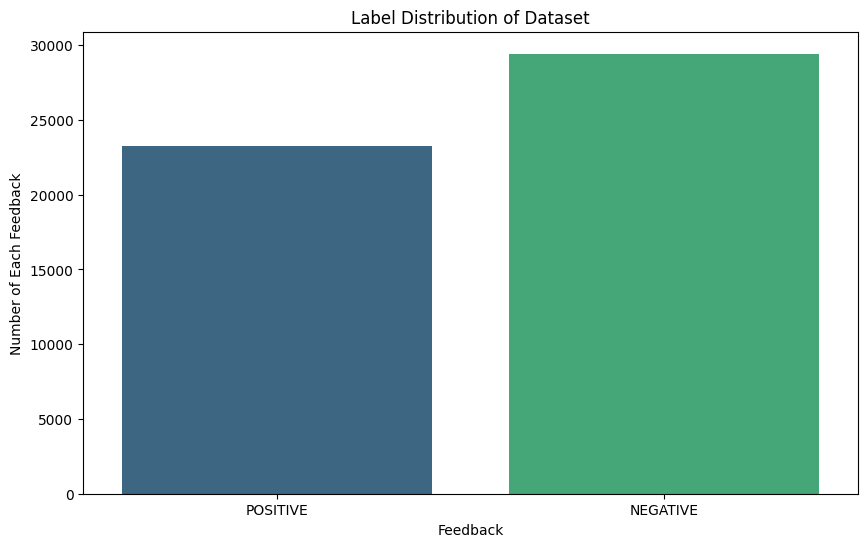

In [ ]:
# Visualize the distribution of labels in the dataset
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x=df_1['label'], data=df_1, palette='viridis')  # Create a count plot for 'label' column
plt.title('Label Distribution of Dataset')  # Add a title
plt.xlabel('Feedback')  # Label the x-axis
plt.ylabel('Number of Each Feedback')  # Label the y-axis
plt.show()  # Display the plot

To check whether the labels used for prediction were imbalanced, I created a visualization. The graph confirmed the presence of **imbalance in the labels**, which is why I chose the F1-Score as the validation metric. **F1-Score** is more suitable for datasets with imbalanced labels as it considers both precision and recall.

# Text Cleaning

I cleaned the text data by removing HTML tags, punctuation, and any characters that could disrupt the analysis. This step improved the semantic understanding of the text.

In [ ]:
# Define a function for cleaning text data
def text_cleaning(text):
    text = re.sub(r'Ã[\x80-\xBF]+', ' ', text)  # Remove specific unwanted characters
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    pattern = r"[^a-zA-Z0-9\s,']"  # Define pattern to retain alphanumeric and some punctuation
    text = re.sub(pattern, '', text)  # Apply pattern to remove unwanted characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading and trailing whitespace
    return text.lower()  # Convert text to lowercase

In [ ]:
# Apply the text cleaning function to the 'review' column
df_1['review'] = df_1['review'].apply(text_cleaning)

###Tokenization

Next, I performed tokenization, which converts sentences into arrays of words. This process is an essential step to transform sentences into a format that computers can process and understand.



In [ ]:
# Define a function to tokenize text into individual words
def tokenize_text(text):
    token = word_tokenize(text)  # Tokenize the text into words
    return token

In [ ]:
# Apply the tokenization function to the 'review' column and create a new column 'token'
df_1['token'] = df_1['review'].apply(tokenize_text)

In [ ]:
# Display the first few rows of the DataFrame to inspect the new 'token' column
df_1.head()

,review,label,token
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of..."
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ..."


###Removing Stopwords


I removed stopwords—common words such as "I," "me," "you," "he," "she," "on," "in," "to," "and," "or," "but," "if," and others. These words do not contribute significant meaning to a sentence. By removing them, I reduced the complexity of the data and focused on the words most relevant to the analysis.

In [ ]:

# Define a custom list of stopwords (domain-specific or additional stopwords)
custom_stopwords = {'app', 'spotify', 'listen', 'please'}


# Define a function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))  # Load NLTK's list of English stopwords
    if custom_stopwords:
        stop_words.update(custom_stopwords)  # Add custom stopwords to the set
    # Remove any token that is in the stop_words set
    return [word for word in tokens if word.lower() not in stop_words]

In [ ]:
df_1['no_stopwords_tokens'] = df_1['token'].apply(remove_stopwords)# Apply the stopword removal function to the 'token' column and and create a new column 'no_stopwords_tokens'
df_1.head(10)# Display the first 10 rows of the DataFrame to inspect the 'no_stopwords_tokens' column


,review,label,token,no_stopwords_tokens
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]"
5,the player controls sometimes disappear for no...,NEGATIVE,"[the, player, controls, sometimes, disappear, ...","[player, controls, sometimes, disappear, reaso..."
6,i love the selection and the lyrics are provid...,POSITIVE,"[i, love, the, selection, and, the, lyrics, ar...","[love, selection, lyrics, provided, song, list..."
7,still extremely slow when changing storage to ...,NEGATIVE,"[still, extremely, slow, when, changing, stora...","[still, extremely, slow, changing, storage, ex..."
8,it s a great app and the best mp3 music app i ...,POSITIVE,"[it, s, a, great, app, and, the, best, mp3, mu...","[great, best, mp3, music, ever, used, one, pro..."
9,i m deleting this app for the following reason...,NEGATIVE,"[i, m, deleting, this, app, for, the, followin...","[deleting, following, reasons, failing, busine..."


###Lemmatization

This step involves **lemmatization**, a process of reducing words to their root forms. While stemming serves a similar purpose, I chose lemmatization for its greater accuracy. This step ensures a consistent understanding of the text and improves the processing quality for downstream tasks.

In [ ]:
# Initialize the WordNetLemmatizer for lemmatizing words
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Apply the lemmatization function to the 'no_stopwords_tokens' column and create a new column 'lemmatized_tokens'
df_1['lemmatized_tokens'] = df_1['no_stopwords_tokens'].apply(lemmatize_tokens)

# Display the first few rows of the DataFrame to inspect the 'lemmatized_tokens' column
df_1.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]"


# EDA

Next, I analyzed how the words and sentence patterns differ between negative and positive feedback. Additionally, I aimed to identify what aspects of our organization each feedback segment referred to, so we can use these insights to improve our product quality.

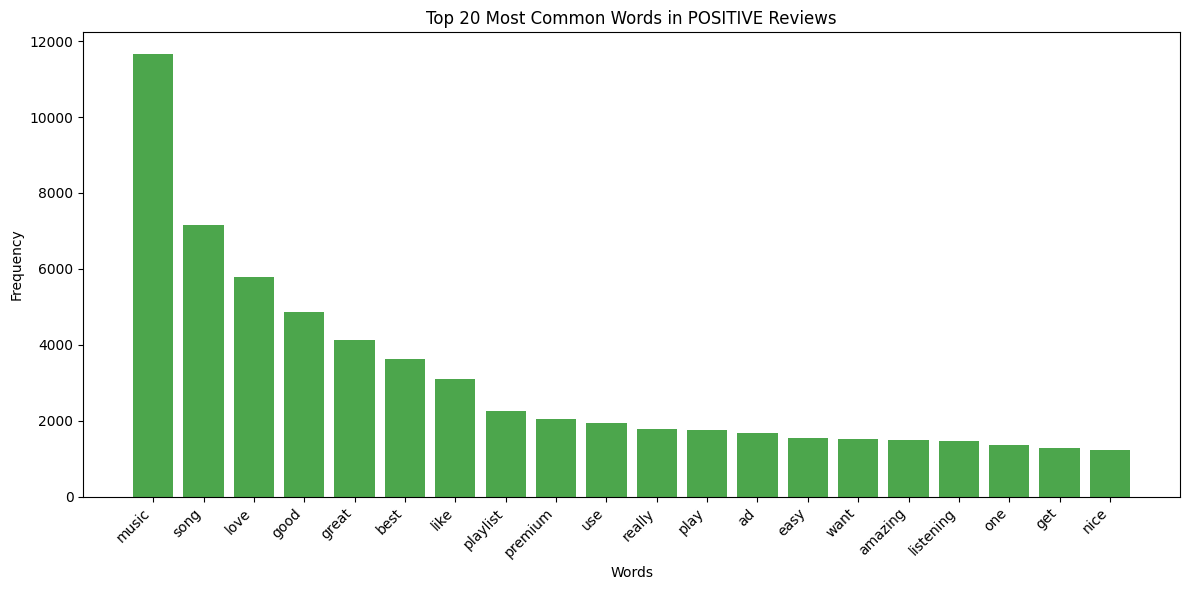

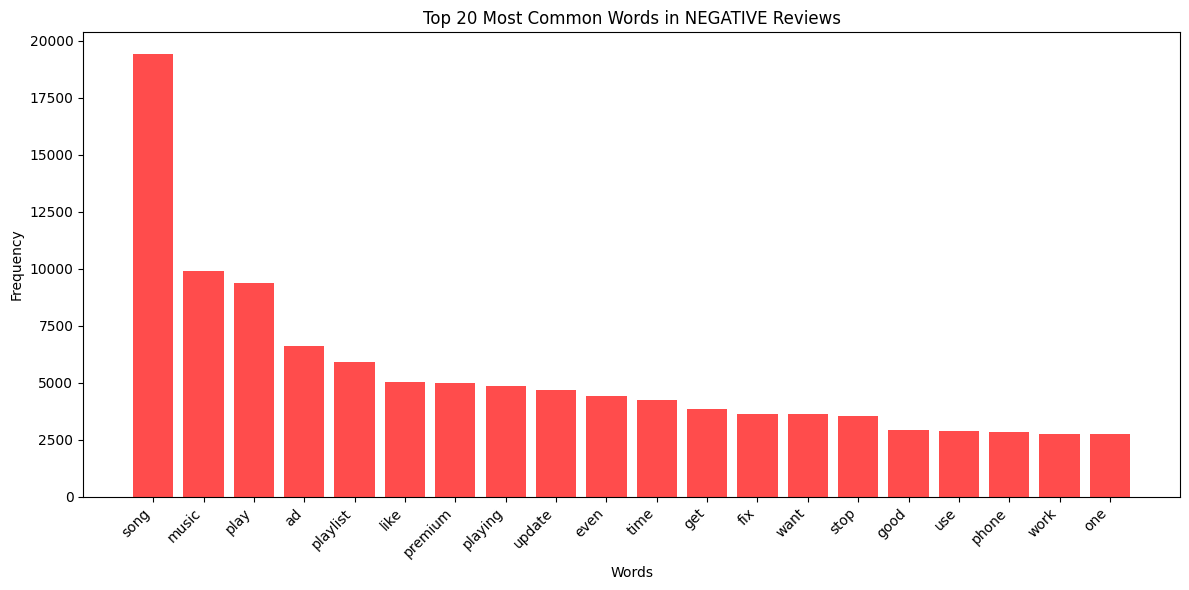

In [ ]:
# Separate reviews into POSITIVE and NEGATIVE labels
pos_df_1 = df_1[df_1['label'] == 'POSITIVE']
neg_df_1 = df_1[df_1['label'] == 'NEGATIVE']

# Count words in POSITIVE and NEGATIVE reviews
pos_before_count = [word for tokens in pos_df_1['lemmatized_tokens'] for word in tokens]
neg_before_count = [word for tokens in neg_df_1['lemmatized_tokens'] for word in tokens]

# Use Counter to find the most frequent words
pos_word_counts = Counter(pos_before_count)
neg_word_counts = Counter(neg_before_count)

# Get the 20 most common words for each label
most_common_pos = pos_word_counts.most_common(20)
most_common_neg = neg_word_counts.most_common(20)

# Separate words and counts for plotting
pos_words, pos_counts = zip(*most_common_pos)
neg_words, neg_counts = zip(*most_common_neg)

# Plot bar chart for most common words in POSITIVE reviews
plt.figure(figsize=(12, 6))
plt.bar(pos_words, pos_counts, color='green', alpha=0.7)
plt.title('Top 20 Most Common Words in POSITIVE Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot bar chart for most common words in NEGATIVE reviews
plt.figure(figsize=(12, 6))
plt.bar(neg_words, neg_counts, color='red', alpha=0.7)
plt.title('Top 20 Most Common Words in NEGATIVE Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare text data (Filtered Tokens)
pos_doc = pos_df_1['lemmatized_tokens'].tolist()  # List of tokenized POSITIVE reviews
neg_doc = neg_df_1['lemmatized_tokens'].tolist()  # List of tokenized NEGATIVE reviews

# Convert tokens back into text for POSITIVE and NEGATIVE reviews
pos_text = [" ".join(tokens) for tokens in pos_doc]  # Text from POSITIVE reviews
neg_text = [" ".join(tokens) for tokens in neg_doc]  # Text from NEGATIVE reviews

# Apply BERTopic for topic modeling on POSITIVE reviews
topic_model_pos = BERTopic()
pos_topics, pos_probs = topic_model_pos.fit_transform(pos_text)  # Train and get topics
print("POSITIVE Topics Info:")  # Display topic info
print(topic_model_pos.get_topic_info())

# Apply BERTopic for topic modeling on NEGATIVE reviews
topic_model_neg = BERTopic()
neg_topics, neg_probs = topic_model_neg.fit_transform(neg_text)  # Train and get topics
print("NEGATIVE Topics Info:")  # Display topic info
print(topic_model_neg.get_topic_info())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

POSITIVE Topics Info:
     Topic  Count                                   Name  \
0       -1   7433               -1_song_like_artist_love   
1        0   1258   0_podcasts_podcast_episode_listening   
2        1    796            1_playlist_list_create_make   
3        2    703               2_premium_plan_worth_pay   
4        3    462                3_ad_annoying_30_minute   
..     ...    ...                                    ...   
285    284     10              284_simple_easy_fast_rock   
286    285     10                 285_tom_ever_yous_seen   
287    286     10  286_algorithm_yu_harvest_optimization   
288    287     10           287_eno_grooving_puppy_brian   
289    288     10                288_star_glitch_iam_zee   

                                        Representation  \
0    [song, like, artist, love, time, new, play, fe...   
1    [podcasts, podcast, episode, listening, also, ...   
2    [playlist, list, create, make, making, creatin...   
3    [premium, plan, wort

In [ ]:
# Visualize topics for POSITIVE reviews
topic_model_pos.visualize_topics()

In [ ]:
# Visualize topics for NEGATIVE reviews
topic_model_neg.visualize_topics()

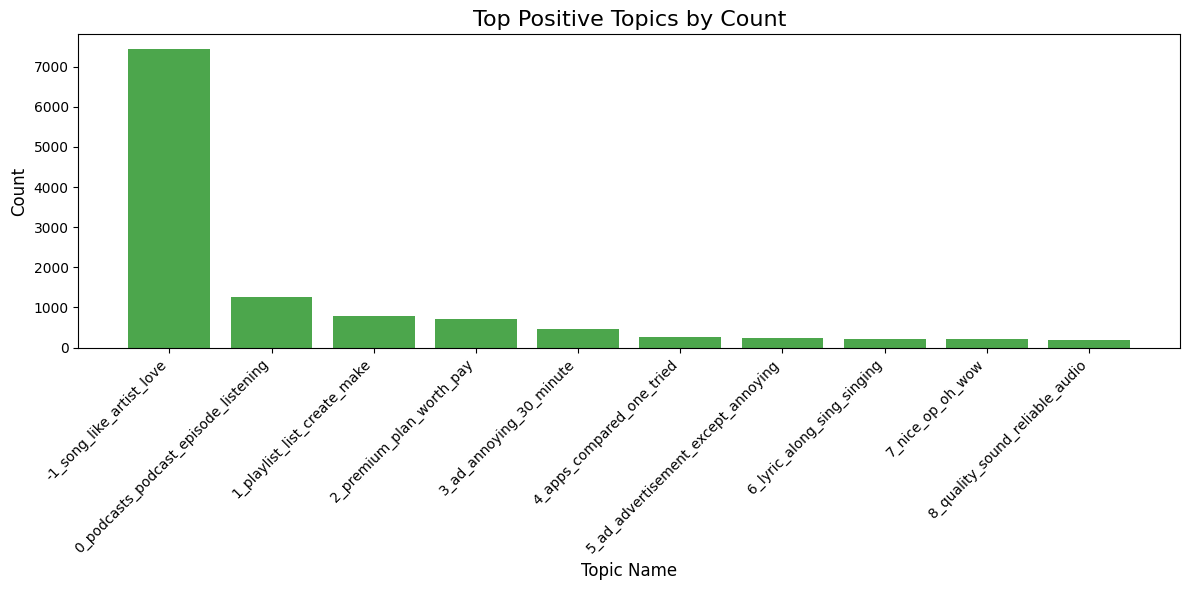

In [ ]:
# Get detailed topic information
positive_topics_info = topic_model_pos.get_topic_info()
negative_topics_info = topic_model_neg.get_topic_info()

# Select the top N topics for display
top_n = 10  # Number of topics to display
positive_topics = positive_topics_info.head(top_n)
negative_topics = negative_topics_info.head(top_n)

# Plot bar chart for top POSITIVE topics by count
plt.figure(figsize=(12, 6))
plt.bar(positive_topics['Name'], positive_topics['Count'], color='green', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top Positive Topics by Count', fontsize=16)
plt.xlabel('Topic Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

From the graphs and data visualizations showing the volume of **positive feedback**, the key points discussed include:

1. The playlists created were highly appealing to users.
2. Podcasts had good recommendations for each episode, especially those featuring Joe Rogan’s channel.
3. he value of subscribing to the premium service was highlighted positively.

However, there were also suggestions about reducing the excessive duration of advertisements.

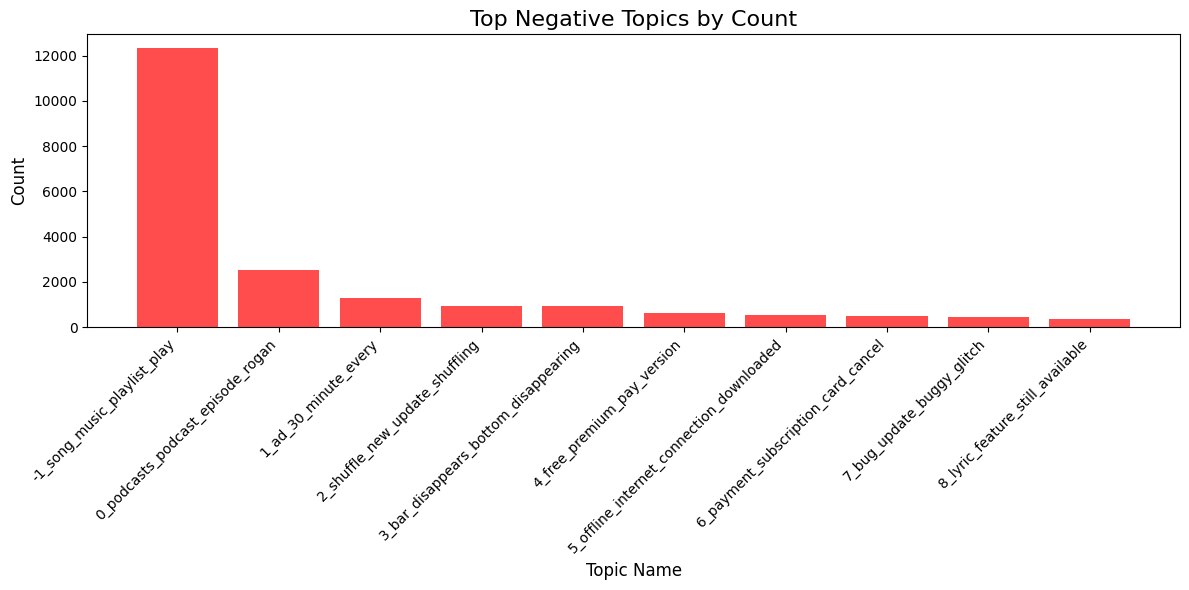

In [ ]:
# Plot bar chart for top NEGATIVE topics by count
plt.figure(figsize=(12, 6))
plt.bar(negative_topics['Name'], negative_topics['Count'], color='red', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top Negative Topics by Count', fontsize=16)
plt.xlabel('Topic Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

From the graphs and data visualizations of **negative feedback**, we observed that users mentioned:
1. Playlist arrangements that did not align with listener preferences.
2. Podcasts referring to episodes or channels with Joe Rogan, which might have been polarizing.
3. Advertisements playing every 30 minutes, which was a common complaint.

### Summary

In summary, both positive and negative feedback shared common themes such as playlist management, which received mixed responses depending on user preferences. The mention of Joe Rogan in podcasts might have coincided with the timing of feedback collection. Positive feedback uniquely highlighted the value of subscribing, while both feedback types discussed the **frequency of advertisements every 30 minutes.** This ad frequency appears to be a significant pain point that may require further discussion and resolution.

#Processing Data

In this step, I prepared the data for input into machine learning models. The goal of data preparation was to format it into a structure that computers can process efficiently.

In [ ]:
# Make a copy of the original DataFrame
df2 = df_1.copy()
df2.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens
0,great music service the audio is high quality ...,POSITIVE,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,POSITIVE,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,NEGATIVE,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,NEGATIVE,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,NEGATIVE,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]"


### Label Encoding

 I converted the labels into integers to make them suitable for model training.

In [ ]:
# Map 'label' column to binary values (1 for POSITIVE, 0 for NEGATIVE)
df2['label'] = df2['label'].map({'POSITIVE': 1, 'NEGATIVE': 0})
df2.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens
0,great music service the audio is high quality ...,1,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating this ap...,1,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr..."
2,this pop up get the best spotify experience on...,0,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno..."
3,really buggy and terrible to use as of recently,0,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn t ...,0,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]"


### Vectorization

In this step,i prepared the data with **Vectorization** , Vectorization is the process of transforming non-numeric data (such as text, images, or audio) into numerical representations (vectors). This step is essential for leveraging mathematical and statistical techniques in data analysis and machine learning.

For this project, I used **TF-IDF** (Term Frequency-Inverse Document Frequency) as the vectorization method. This technique counts word frequency within a sentence while considering how often each word appears across all sentences. It helps prioritize unique and meaningful words.

In [ ]:

# Convert lemmatized tokens into a single string for each review
df2['tfidf_converted'] = df2['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer to extract features from text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
# Transform the text data into a sparse matrix of TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['tfidf_converted'])

# Retrieve feature names for inspection or analysis
feature_names = tfidf_vectorizer.get_feature_names_out()

# Save the TF-IDF vectorizer for future use
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

df2.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens,tfidf_converted
0,great music service the audio is high quality ...,1,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ...",great music service audio high quality easy us...
1,please ignore previous negative rating this ap...,1,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr...",ignore previous negative rating super great gi...
2,this pop up get the best spotify experience on...,0,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno...",pop get best experience android 12 annoying le...
3,really buggy and terrible to use as of recently,0,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]",really buggy terrible use recently
4,dear spotify why do i get songs that i didn t ...,0,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]",dear get song put playlist shuffle play


# Supervised Learning Model

Before feeding the data into the models, I performed a train-test split to separate the data into training and testing sets. The training set was used for model training, while the test set evaluated the model's performance. This process helps mitigate the issue of overfitting.

I experimented with five models:
*   Logistic Regression
*   Random Forest
*   Multinomial Naive Bayes
*   Decision Tree
*   XGBoost

After evaluating the results, I found that Logistic Regression performed the best. I chose this model for deployment.

In [ ]:
# Define features (X) and target labels (y)
X = tfidf_matrix
y = df2['label']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# USING LOGISTIC REGRESSION
model = LogisticRegression()
model.fit(X_train, y_train)  # Train the model
y_pred = model.predict(X_test)  # Predict on the test set
f1_score_test = f1_score(y_test, y_pred)  # Calculate F1 score
print(f"Logistic Regression F-1 Score: {f1_score_test:.4f}")

Logistic Regression F-1 Score: 0.8613


In [ ]:
# USING RANDOM FOREST CLASSIFIER
model = RandomForestClassifier()
model.fit(X_train, y_train)  # Train the model
y_pred = model.predict(X_test)  # Predict on the test set
f1_score_test = f1_score(y_test, y_pred)  # Calculate F1 score
print(f"Random Forest Classifier F-1 Score: {f1_score_test:.4f}")

Random Forest Classifier F-1 Score: 0.8357


In [ ]:
# USING MULTINOMIAL NAIVE BAYES MODEL
model = MultinomialNB(alpha=0.5)  # Set smoothing parameter alpha
model.fit(X_train, y_train)  # Train the model
y_pred = model.predict(X_test)  # Predict on the test set
f1_score_test = f1_score(y_test, y_pred)  # Calculate F1 score
print(f"Multinomial Naive Bayes F-1 Score: {f1_score_test:.4f}")

Multinomial Naive Bayes  F-1 Score: 0.8383


In [ ]:
# USING Decision Tree CLASSIFIER
model = DecisionTreeClassifier()
model.fit(X_train, y_train) # Train the model
y_pred = model.predict(X_test) # Predict on the test set
f1_score_test = f1_score(y_test, y_pred) # Calculate F1 score
print(f"Decision Tree  F-1 Score: {f1_score_test:.4f}")

Decision Tree  F-1 Score: 0.7749


In [ ]:
# USING XGBOOST CLASSIFIER
model = XGBClassifier()
model.fit(X_train, y_train)  # Train the model
y_pred = model.predict(X_test)  # Predict on the test set
f1_score_test = f1_score(y_test, y_pred)  # Calculate F1 score
print(f"XGBoost F-1 Score: {f1_score_test:.4f}")

XGBoost  F-1 Score: 0.8294


###Hyperparameter Tuning

Before deploying the Logistic Regression model, I performed hyperparameter tuning to find the optimal parameters, ensuring the best possible performance for the model.



In [ ]:
# TUNING LOGISTIC REGRESSION HYPERPARAMETERS USING GRID SEARCH

# Define a range for the max_iter parameter
max_iter_values = np.arange(15, 26)

# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'max_iter': max_iter_values,  # Maximum iterations for optimization
}

# Initialize the Logistic Regression model
model = LogisticRegression()

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='f1',  # Use F1 score as the evaluation metric
                           cv=5,  # Perform 5-fold cross-validation
                           refit=True,  # Use the best model for predictions
                           verbose=3,  # Display detailed output
                           n_jobs=-1)  # Use all available CPU cores

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Predict on the test set using the best model from GridSearchCV
grid_predictions = grid_search.predict(X_test)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


In [ ]:
# print best parameter after tuning
print(grid_search.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid_search.best_estimator_)

{'C': 1, 'max_iter': 20, 'penalty': 'l2'}
LogisticRegression(C=1, max_iter=20)


In [ ]:
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5864
           1       0.87      0.85      0.86      4674

    accuracy                           0.88     10538
   macro avg       0.88      0.88      0.88     10538
weighted avg       0.88      0.88      0.88     10538



In [ ]:
# Evaluate the best model's performance on the test set
best_model = grid_search.best_estimator_
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5864
           1       0.85      0.81      0.83      4674

    accuracy                           0.85     10538
   macro avg       0.85      0.85      0.85     10538
weighted avg       0.85      0.85      0.85     10538



###Model Deployment


Finally, I loaded the best-performing model to deploy it as an API for practical use.



In [ ]:
# Save the best Logistic Regression model
joblib.dump(grid_search.best_estimator_, 'best_logistic_regression_model.pkl')

['best_logistic_regression_model.pkl']

# Deep Learning Model

In this step, I aimed to train the data using a deep learning model to evaluate whether it would yield better results compared to the previous approaches.

###Building a Vocabulary


I started by creating a vocabulary, which is a dictionary containing all the unique words in the dataset. Each word was assigned a unique numeric value, allowing it to be referenced in subsequent processing steps.

In [ ]:
# create Vocabulary from all words from df['token']
def build_vocabulary(token_column):
    vocab = {"<PAD>": 0}  # Start the vocabulary with a special token <PAD> for padding
    idx = 1  # Index starts from 1 (0 is reserved for <PAD>)
    for tokens in token_column:
        for token in tokens:
            if token not in vocab:  # If the token is not already in the vocabulary
                vocab[token] = idx  # Assign the current index to the token
                idx += 1  # Increment the index
    return vocab

# Build vocabulary from the 'token' column
vocab = build_vocabulary(df2['token'])
# Output the size of the vocabulary
print(f"Vocabulary Size: {len(vocab)}")

Vocabulary Size: 21668


In [ ]:
print(vocab)

{'<PAD>': 0, 'great': 1, 'music': 2, 'service': 3, 'the': 4, 'audio': 5, 'is': 6, 'high': 7, 'quality': 8, 'and': 9, 'app': 10, 'easy': 11, 'to': 12, 'use': 13, 'also': 14, 'very': 15, 'quick': 16, 'friendly': 17, 'support': 18, 'please': 19, 'ignore': 20, 'previous': 21, 'negative': 22, 'rating': 23, 'this': 24, 'super': 25, 'i': 26, 'give': 27, 'it': 28, 'five': 29, 'stars': 30, 'pop': 31, 'up': 32, 'get': 33, 'best': 34, 'spotify': 35, 'experience': 36, 'on': 37, 'android': 38, '12': 39, 'too': 40, 'annoying': 41, 'let': 42, 's': 43, 'rid': 44, 'of': 45, 'really': 46, 'buggy': 47, 'terrible': 48, 'as': 49, 'recently': 50, 'dear': 51, 'why': 52, 'do': 53, 'songs': 54, 'that': 55, 'didn': 56, 't': 57, 'put': 58, 'my': 59, 'playlist': 60, 'we': 61, 'have': 62, 'shuffle': 63, 'play': 64, 'player': 65, 'controls': 66, 'sometimes': 67, 'disappear': 68, 'for': 69, 'no': 70, 'reason': 71, 'restart': 72, 'forgets': 73, 'what': 74, 'was': 75, 'playing': 76, 'but': 77, 'fixes': 78, 'issue': 79

In [ ]:
# Save the vocabulary as a JSON file for later use
with open('vocab.json', 'w') as f:
    json.dump(vocab, f)

###Converting Words to Numeric Values

Next, I converted each word into its corresponding numeric value based on the vocabulary. This step prepared the data for input into the embedding layer of the deep learning model

In [ ]:
#Convert a list of tokens into their corresponding indices using the vocabulary.
def tokens_to_indices(tokens, vocab):
    return [vocab[token] for token in tokens if token in vocab]
# Apply token-to-index conversion to the 'token' column
df2['token_indices'] = df2['token'].apply(lambda tokens: tokens_to_indices(tokens, vocab))

In [ ]:
df2.head()

,review,label,token,no_stopwords_tokens,lemmatized_tokens,tfidf_converted,token_indices
0,great music service the audio is high quality ...,1,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ...","[great, music, service, audio, high, quality, ...",great music service audio high quality easy us...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 4, 10, 6, 11, 12, ..."
1,please ignore previous negative rating this ap...,1,"[please, ignore, previous, negative, rating, t...","[ignore, previous, negative, rating, super, gr...","[ignore, previous, negative, rating, super, gr...",ignore previous negative rating super great gi...,"[19, 20, 21, 22, 23, 24, 10, 6, 25, 1, 26, 27,..."
2,this pop up get the best spotify experience on...,0,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, experience, android, 12, anno...","[pop, get, best, experience, android, 12, anno...",pop get best experience android 12 annoying le...,"[24, 31, 32, 33, 4, 34, 35, 36, 37, 38, 39, 6,..."
3,really buggy and terrible to use as of recently,0,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]",really buggy terrible use recently,"[46, 47, 9, 48, 12, 13, 49, 45, 50]"
4,dear spotify why do i get songs that i didn t ...,0,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, get, songs, put, playlist, shuffle, play]","[dear, get, song, put, playlist, shuffle, play]",dear get song put playlist shuffle play,"[51, 35, 52, 53, 26, 33, 54, 55, 26, 56, 57, 5..."


### Padding

The padding step ensured that all input data had a uniform size. The maximum sequence length in the dataset was 287, so I padded all sequences to this length. This uniformity is critical for deep learning models, as they require fixed input sizes for computation. Padding is an essential preprocessing step before feeding data into the model.

In [ ]:
# Convert the token indices column to a list of lists
list_w = df2['token_indices'].tolist()

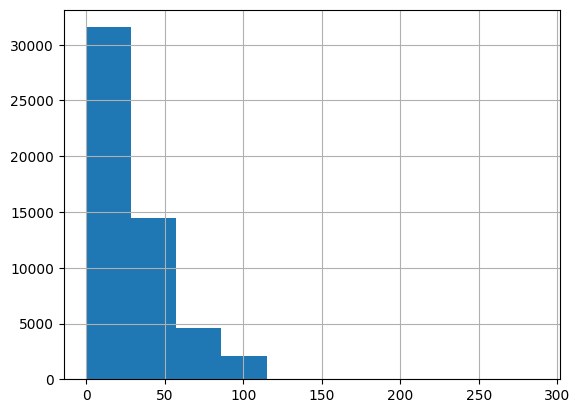

,0
count,52686.000000
mean,29.286490
std,23.542213
min,0.000000
25%,11.000000
50%,22.500000
75%,40.000000
max,287.000000


In [ ]:
# Analyze the distribution of sequence lengths in the dataset.
# Calculate the length of each sequence
reviews_len = [len(x) for x in list_w]
pd.Series(reviews_len).hist() # Plot a histogram of sequence lengths
plt.show()
pd.Series(reviews_len).describe()# Display statistical information about sequence lengths

In [ ]:
#Create a function to ensure that all sequences are of the same length (seq_length) by appending or truncating as necessary.
def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype=int)  # Initialize with zeros for padding

    for i, review in enumerate(reviews_int):
        review_len = len(review)  # Current review length

        if review_len <= seq_length:  # If the sequence is shorter than `seq_length`
            zeroes = list(np.zeros(seq_length - review_len))  # Add padding at the beginning
            new = zeroes + review
        elif review_len > seq_length:  # If the sequence is longer
            new = review[:seq_length]  # Truncate to `seq_length`

        features[i, :] = np.array(new)  # Assign the padded/truncated sequence
    return features


In [ ]:
# Pad/truncate sequences to a length of 287
features = pad_features(list_w,287)

In [ ]:
# Display the first 10 padded/truncated sequences
print(features[:10,:])

[[  0   0   0 ...   9  17  18]
 [  0   0   0 ...  28  29  30]
 [  0   0   0 ...  44  45  24]
 ...
 [  0   0   0 ... 129 130 131]
 [  0   0   0 ... 145   4  34]
 [  0   0   0 ...   6 189 190]]


In [ ]:
type(features) # Check type of features

numpy.ndarray

###Train-Test Split


Similar to the preparation for supervised learning models, I split the data into training and testing sets. However, since I was using PyTorch, I prepared the data as a Tensor Dataset, which is the optimal format for GPU processing in deep learning tasks.

In [ ]:
len_feat = len(features)  # Total number of sequences
split_frac = 0.8  # 80% for training

# Labels as a list
encoded_labels = df2['label'].tolist()

# Training set
train_x = features[:int(split_frac * len_feat)]
train_y = encoded_labels[:int(split_frac * len_feat)]

# Remaining data for validation and test sets
remaining_x = features[int(split_frac * len_feat):]
remaining_y = encoded_labels[int(split_frac * len_feat):]

# Split the remaining data equally for validation and test sets
valid_x = remaining_x[:int(len(remaining_x) * 0.5)]
valid_y = remaining_y[:int(len(remaining_y) * 0.5)]
test_x = remaining_x[int(len(remaining_x) * 0.5):]
test_y = remaining_y[int(len(remaining_y) * 0.5):]

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

### Building the LSTM Model


In this step, I will build the model for processing the data. I chose to use an **LSTM** (Long Short-Term Memory) model, a deep learning architecture implemented with PyTorch. LSTMs are particularly effective for sequence-based data, as they are designed to capture temporal dependencies and context over time. Given that sentences and words naturally form sequential data, LSTMs are well-suited for this project, which focuses on sentiment analysis. The task involves classifying whether the sentiment in a given text is positive or negative.

In [ ]:
class SentimentLSTM(nn.Module):


    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        """
        Initialize the model by setting up the layers.

        Parameters:
        - vocab_size: The size of the vocabulary (number of unique words).
        - output_size: The number of output classes (1 for binary classification).
        - embedding_dim: The dimensionality of the word embeddings.
        - hidden_dim: The number of units in the LSTM hidden layer.
        - n_layers: The number of stacked LSTM layers.
        - drop_prob: The dropout probability to prevent overfitting.
        """

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding layer: Maps words to dense vectors of fixed size (embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer: Processes sequences of embeddings and captures temporal dependencies
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # Dropout layer: Randomly sets some outputs to zero during training to prevent overfitting
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer: Maps the LSTM output to the desired output size
        self.fc = nn.Linear(hidden_dim, output_size)

        # Sigmoid layer: Outputs probabilities for binary classification
        self.sig = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

### Setting Training and Testing Parameters


I will configure the parameters for training and testing the dataset. The model will be trained for 4 epochs, after which it will be tested to evaluate its performance on unseen data.

In [ ]:
# Instantiate the model with hyperparameters
vocab_size = len(vocab) + 1  # Vocabulary size (+1 for padding token)
output_size = 1  # Binary output (positive or negative sentiment)
embedding_dim = 400  # Dimensionality of word embeddings
hidden_dim = 128  # Number of units in LSTM hidden layer
n_layers = 2  # Number of stacked LSTM layers

# Create the model instance
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

# Print the model architecture for verification
print(model)

SentimentLSTM(
  (embedding): Embedding(21669, 400)
  (lstm): LSTM(400, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# Check if GPU is available for training
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

# Define the loss function (Binary Cross-Entropy Loss for binary classification)
criterion = nn.BCELoss()

# Define the optimizer (Adam optimizer with learning rate of 0.001)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Training on GPU.


In [ ]:
# Training parameters
epochs = 4  # Number of epochs for training, based on when the validation loss starts to stabilize
counter = 0  # A counter to keep track of the number of steps
print_every = 100  # Print loss statistics every 100 steps
clip = 5  # Gradient clipping value to prevent exploding gradients

# Move model to GPU if available
if train_on_gpu:
    model.cuda()  # Move the model to GPU

model.train()  # Set the model to training mode (important for dropout layers, batch norm, etc.)

# Training loop for multiple epochs
for e in range(epochs):
    # Initialize hidden state for LSTM (this will reset at the start of each epoch)
    h = model.init_hidden(batch_size)

    # Loop through each batch of data from the training data loader
    for inputs, labels in train_loader:
        counter += 1  # Increment the step counter

        if train_on_gpu:  # Move input and label data to GPU if available
            inputs, labels = inputs.cuda(), labels.cuda()

        # Initialize the hidden state for this batch of data
        h = model.init_hidden(inputs.size(0))  # Initialize hidden state with the batch size
        h = tuple([each.data for each in h])  # Detach hidden state from the previous step (prevents backprop through the entire history)

        # Zero the accumulated gradients (important for each step)
        model.zero_grad()

        # Get the model's predictions (forward pass)
        output, h = model(inputs, h)

        # Calculate the loss (how far off the model's predictions are from the true labels)
        loss = criterion(output.squeeze(), labels.float())  # Squeeze the output to match labels dimensions and compute the loss
        loss.backward()  # Perform backpropagation to compute the gradients

        # Apply gradient clipping to prevent exploding gradients (particularly useful for RNNs/LSTMs)
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update model parameters using the optimizer
        optimizer.step()

        # Print loss statistics periodically
        if counter % print_every == 0:
            # Get the validation loss for this step
            val_losses = []
            model.eval()  # Set the model to evaluation mode (disables dropout, etc.)

            # Loop through the validation data loader
            for inputs, labels in valid_loader:
                # Initialize the hidden state for validation data
                val_h = model.init_hidden(inputs.size(0))  # Initialize hidden state for validation batch
                val_h = tuple([each.data for each in val_h])  # Detach hidden state from previous step

                if train_on_gpu:  # Move validation data to GPU if available
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Get the model's predictions for the validation data
                output, val_h = model(inputs, val_h)

                # Calculate the validation loss
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())  # Store the validation loss

            model.train()  # Switch back to training mode for further steps

            # Print training and validation loss statistics
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


Epoch: 1/4... Step: 100... Loss: 0.469307... Val Loss: 0.396482
Epoch: 1/4... Step: 200... Loss: 0.268550... Val Loss: 0.353622
Epoch: 1/4... Step: 300... Loss: 0.198159... Val Loss: 0.322397
Epoch: 1/4... Step: 400... Loss: 0.296706... Val Loss: 0.347960
Epoch: 1/4... Step: 500... Loss: 0.362183... Val Loss: 0.300867
Epoch: 1/4... Step: 600... Loss: 0.157573... Val Loss: 0.316402
Epoch: 1/4... Step: 700... Loss: 0.195140... Val Loss: 0.287861
Epoch: 1/4... Step: 800... Loss: 0.295289... Val Loss: 0.292674
Epoch: 2/4... Step: 900... Loss: 0.162144... Val Loss: 0.278836
Epoch: 2/4... Step: 1000... Loss: 0.162935... Val Loss: 0.277630
Epoch: 2/4... Step: 1100... Loss: 0.149316... Val Loss: 0.267481
Epoch: 2/4... Step: 1200... Loss: 0.159897... Val Loss: 0.269959
Epoch: 2/4... Step: 1300... Loss: 0.365862... Val Loss: 0.277251
Epoch: 2/4... Step: 1400... Loss: 0.213354... Val Loss: 0.267683
Epoch: 2/4... Step: 1500... Loss: 0.189565... Val Loss: 0.295117
Epoch: 2/4... Step: 1600... Loss: 

In [ ]:
# Initialize lists to store predictions and true labels
all_preds = []  # For storing the predicted class labels (0 or 1)
all_labels = []  # For storing the actual class labels (0 or 1)

# Iterate over the test data
for inputs, labels in test_loader:
    # Initialize hidden state for each batch in the test set
    h = model.init_hidden(inputs.size(0))  # Batch size of the test data
    h = tuple([each.data for each in h])  # Detach hidden state from the previous batch to avoid backpropagation through the entire history

    # Move data to GPU if available
    if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()

    # Get the model's predicted outputs (forward pass)
    output, h = model(inputs, h)

    # Convert the output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # Round the output probabilities to the nearest integer (either 0 or 1)

    # Store the predictions and the actual labels for later evaluation
    all_preds.extend(pred.cpu().detach().numpy())  # Move predictions to CPU and convert to numpy for further analysis
    all_labels.extend(labels.cpu().detach().numpy())  # Move labels to CPU and convert to numpy

# Calculate precision, recall, and F1-score based on predictions and true labels
precision = precision_score(all_labels, all_preds)  # Calculate precision (positive predictive value)
recall = recall_score(all_labels, all_preds)  # Calculate recall (true positive rate)
f1 = f1_score(all_labels, all_preds)  # Calculate F1-score (harmonic mean of precision and recall)

# Print the evaluation metrics
print(f"Precision: {precision:.3f}")  # Print precision rounded to 3 decimal places
print(f"Recall: {recall:.3f}")  # Print recall rounded to 3 decimal places
print(f"F1-Score: {f1:.3f}")  # Print F1-score rounded to 3 decimal places


Precision: 0.982
Recall: 0.887
F1-Score: 0.932


Impressive performance! I will save this LSTM model alongside the Logistic Regression model to use both in production. These models will be deployed as two separate APIs, allowing users to make predictions based on their preferred approach.

In [ ]:
#Saving the Model with only weight
torch.save(model.state_dict(), "model.pth")